# Analyze molecule embeddings

In [1]:
import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

from jointformer.configs.task import TaskConfig
from jointformer.utils.datasets.auto import AutoDataset
from jointformer.utils.tokenizers.auto import AutoTokenizer
from jointformer.configs.model import ModelConfig
from jointformer.models.auto import AutoModel

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

### Visualization

In [14]:
def two_D_reduction(X, reducer="pca", **reducer_kwargs):
    """
    Performs dimensionality reduction on the input data.

    Args:
        X (array-like): Input data.
        reducer (str, optional): The dimensionality reduction method to use. Options are 'pca', 'tsne', and 'umap'. Defaults to 'pca'.
        **reducer_kwargs: Additional keyword arguments to pass to the dimensionality reduction method.

    Returns:
        array-like: The reduced data.
    """
    if reducer == "pca":
        reducer = PCA(n_components=2, **reducer_kwargs)
    elif reducer == "tsne":
        reducer = TSNE(n_components=2, **reducer_kwargs)
    elif reducer == "umap":
        reducer = umap.UMAP(n_components=2, **reducer_kwargs)
    else:
        raise ValueError(f"Unknown reducer: {reducer}")

    X_reduced = reducer.fit_transform(X)
    return X_reduced

def plot_data_2D_matplotlib(X, reducer, ax=None, **kwargs):
    """
    Plots the reduced data using matplotlib on the provided or a new axis.

    Args:
        X (array-like): Input data.
        reducer (str): The dimensionality reduction method to use. Options are 'pca', 'tsne', and 'umap'.
        ax (matplotlib.axes.Axes, optional): An existing axis to plot on. If None, a new figure and axis are created.
        **kwargs: Additional keyword arguments to pass to plt.scatter and the dimensionality reduction method.

    Returns:
        matplotlib.axes.Axes: The matplotlib axes containing the plot.
    """
    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()

    scatter_kwargs = {k: v for k, v in kwargs.items() if k in list(inspect.signature(plt.scatter).parameters)}
    # Assuming two_D_reduction and PCA are defined elsewhere and properly handle reducer_kwargs
    reducer_kwargs = {k: v for k, v in kwargs.items() if k in list(inspect.signature(PCA).parameters)}

    if reducer == "pca":
        axis_alias = "PCA"
    elif reducer == "tsne":
        axis_alias = "t-SNE"
    elif reducer == "umap":
        axis_alias = "UMAP"
    else:
        raise ValueError(f"Unknown reducer: {reducer}")
    
    # Assuming two_D_reduction is a function defined elsewhere for dimensionality reduction
    X_reduced = two_D_reduction(X, reducer=reducer, **reducer_kwargs)
    X_reduced = pd.DataFrame(X_reduced, columns=[f"{axis_alias}_1", f"{axis_alias}_2"])

    p = ax.scatter(X_reduced[f"{axis_alias}_1"], X_reduced[f"{axis_alias}_2"], **scatter_kwargs)
    if "c" in kwargs:
        plt.colorbar(p, ax=ax)
    ax.set_xlabel(f"{axis_alias}_1")
    ax.set_ylabel(f"{axis_alias}_2")
    if "title" in kwargs:
        ax.set_title(kwargs["title"])

    return ax

### Representations

In [15]:
def compute_embeddings(inputs, model, embedding_func, tokenizer, batch_size=32, **tokenizer_call_kwargs):
    """Compute embeddings in batches."""
    embeddings = []
    for i in range(0, len(inputs), batch_size):
        inputs_batch = tokenizer(inputs[i:i + batch_size], **tokenizer_call_kwargs)
        embeddings_batch = embedding_func(model, inputs_batch)
        embeddings.append(embeddings_batch)
    return torch.cat(embeddings)

### Similarities

In [16]:
def compute_tanimoto_similarity_matrix(smiles_list):
    # Convert SMILES to RDKit molecules
    molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]
    # Generate fingerprints
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in molecules]

    # Compute similarity matrix
    num_molecules = len(fingerprints)
    similarity_matrix = np.zeros((num_molecules, num_molecules))
    for i in range(num_molecules):
        for j in range(i, num_molecules):
            similarity = DataStructs.FingerprintSimilarity(fingerprints[i], fingerprints[j])
            similarity_matrix[i][j] = similarity
            similarity_matrix[j][i] = similarity  # Symmetric matrix
    return similarity_matrix

## Load the data

### Guacamol physchem

In [5]:

PATH_TO_TASK_CONFIG = '../../configs/tasks/guacamol/physchem/'

task_config = TaskConfig.from_config_file(PATH_TO_TASK_CONFIG)
task_config.path_to_vocabulary = "../../data/vocabularies/deepchem.txt"

dataset = AutoDataset.from_config(task_config, split='test')
tokenizer = AutoTokenizer.from_config(task_config)

print(len(dataset))

238706


In [6]:
molecules_list = dataset.data
labels = dataset.target[:, 0, :10]
labels_df = pd.DataFrame(labels, columns=[f"target_{i}" for i in range(labels.shape[1])])


molecules_list = molecules_list[:400]
labels_df = labels_df.iloc[:400]

print(len(molecules_list), labels_df.shape)

400 (400, 10)


## Load the model

In [7]:
!ls ../../../../checkpoints/lm_physchem/

ckpt.pt


In [8]:
# Load the model
PATH_TO_MODEL_CONFIG = '../../configs/models/jointformer/'
PATH_TO_PRETRAINED_MODEL = "../../../../checkpoints/lm_physchem/ckpt.pt"

model_config = ModelConfig.from_config_file(PATH_TO_MODEL_CONFIG)
model = AutoModel.from_config(model_config)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load weights
model.load_pretrained(PATH_TO_PRETRAINED_MODEL)

model.eval()
model.to(device)

INFO: number of parameters: 14.92M


Jointformer(
  (transformer): ModuleDict(
    (wte): Embedding(593, 256)
    (wpe): Embedding(128, 256)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-7): 8 x TransformerBlock(
        (ln_1): LayerNorm()
        (attn_1): SelfAttention(
          (qkv_proj): Linear(in_features=256, out_features=768, bias=False)
          (out_proj): Linear(in_features=256, out_features=256, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (fc): Linear(in_features=256, out_features=1024, bias=False)
          (gelu): GELU(approximate='none')
          (proj): Linear(in_features=1024, out_features=256, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=256, out_features=593, bias=False)
  (mlm_head): Linear(in_features=256, out_features=593, b

## 2D visualizations of embeddings for a set of molecules

In [9]:
# Full workflow

# Define embeddings function
embeddings_func = lambda model, inputs: model(**inputs)["embeddings"].mean(1)

# Compute embeddings
embeddings = compute_embeddings(molecules_list, model, embeddings_func, tokenizer, batch_size=2)

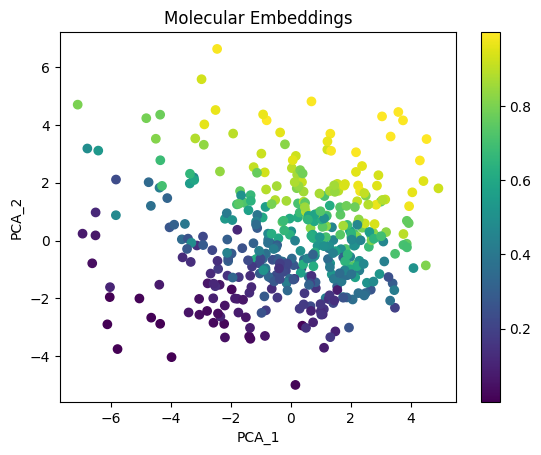

In [10]:
# Visualize embeddings - single target
TARGET = "target_1"

ax = plot_data_2D_matplotlib(embeddings.detach().numpy(), reducer="pca", title="Molecular Embeddings", c=labels_df[TARGET])

plt.show()

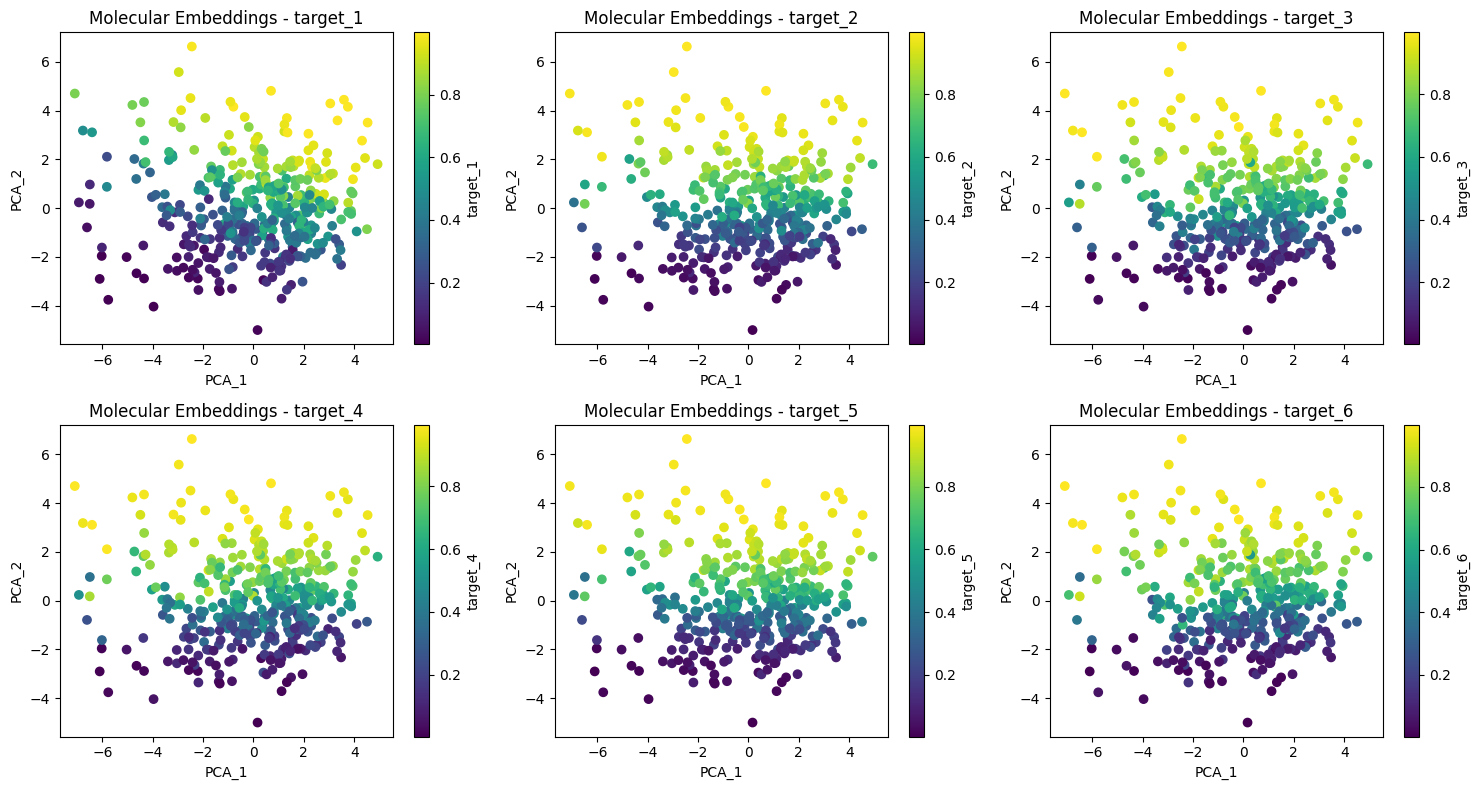

In [22]:
# Visualize embeddings - multiple targets
targets = ["target_1", "target_2", "target_3", "target_4", "target_5", "target_6"]

NUM_COLS = 3
NUM_ROWS = int(np.ceil(len(targets) / NUM_COLS))

fig, axes = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(5 * NUM_COLS, 4 * NUM_ROWS))

for i, target in enumerate(targets):
    ax = axes[i // NUM_COLS, i % NUM_COLS]
    plot_data_2D_matplotlib(embeddings.detach().numpy(), reducer="pca", 
                                 title=f"Molecular Embeddings - {target}", 
                                 c=labels_df[target], 
                                 ax=ax)
    # Add colorbar title
    cbar = ax.collections[0].colorbar
    cbar.set_label(target)

plt.tight_layout()
plt.show()

## Compute similarity matrices

In [27]:
sim_matrix = compute_tanimoto_similarity_matrix(molecules_list)

print(type(sim_matrix), sim_matrix.shape)

sim_matrix[:3, :3]

<class 'numpy.ndarray'> (400, 400)


array([[1.        , 0.11538462, 0.12195122],
       [0.11538462, 1.        , 0.10204082],
       [0.12195122, 0.10204082, 1.        ]])